# 국민여가활동조사 전처리 및 분류 모형 생성

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
data_dir = 'D:/thon/project/tourism/02.국민여가활동조사/3.데이터'
h21 = pd.read_csv(data_dir + '/hobby_21.csv')
h21 = pd.DataFrame(h21)

# 스포츠경험자/스포츠비경험자 칼럼 생성
h21['sports_exp'] = np.NaN # 스포츠경험자 칼럼 생성
h21.loc[(h21['q1_C'] != '99') | (h21['q1_D'] != '99'), 'sports_exp'] = '1' # 스포츠경험자 == 1
h21.loc[(h21['q1_C'] == '99') & (h21['q1_D'] == '99'), 'sports_exp'] = '0' # 스포츠비경험자 == 0

# EDA에서 변수선택으로 추린 변수와 target
df = h21[['q45', 'DM1', 'DM2', 'DM3', 'DM4', 'DM5', 'DM6', 'DM8', 'DM11', 'sports_exp']] # 분석에 사용할 칼럼 추출
df.columns = ['weekly_worked', 'gender', 'age', 'edu', 'family', 'marriage', 'householder', 'income', 'city', 'target'] # 칼럼명 변경
predictor = ['weekly_worked', 'gender', 'age', 'edu', 'family', 'marriage', 'householder', 'income', 'city'] # 분석에 사용할 독립변수 지정
df.head()

C:\Users\sujin\AppData\Local\Temp\ipykernel_8604\2764788701.py:8: DtypeWarning: Columns (90,100,101,102,103,104,105,126) have mixed types. Specify dtype option on import or set low_memory=False.
  h21 = pd.read_csv(data_dir + '/hobby_21.csv')


,weekly_worked,gender,age,edu,family,marriage,householder,income,city,target
0,1,2,7,1,3,2,2,2,15,0
1,1,1,5,3,3,2,1,3,15,0
2,2,2,6,1,3,3,2,2,15,0
3,1,1,5,3,3,3,1,2,15,0
4,1,1,5,3,2,1,1,2,15,1


## 분류모델 및 Feature Importance

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

### train, test 데이터 분리
train, test = train_test_split(df, test_size = 0.3, random_state = 0, stratify = df['target'])
train_X = train[train.columns[:-1]]
train_y = train[train.columns[-1:]]
test_X = test[test.columns[:-1]]
test_y = test[test.columns[-1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1:]]

train_X_dummy = pd.get_dummies(train_X, columns = predictor, drop_first = True)
test_X_dummy = pd.get_dummies(test_X, columns = predictor, drop_first = True)


### 랜덤포레스트

In [20]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(train_X, train_y)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 10}
최고 예측 정확도: 0.7172


c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Accuracy for Random Forests is 0.7071310116086236


C:\Users\sujin\AppData\Local\Temp\ipykernel_8604\1753716136.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)


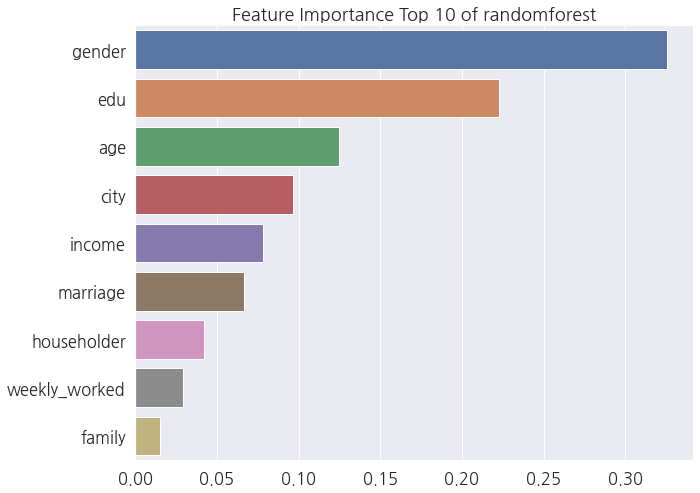

In [37]:
### RandomForest Classification Model

model = RandomForestClassifier(n_estimators = 10, max_depth = 6, min_samples_leaf = 12, min_samples_split = 8, random_state = 11, n_jobs = -1)
model.fit(train_X, train_y)
prediction_rf = model.predict(test_X)
print('Accuracy for Random Forests is', metrics.accuracy_score(prediction_rf, test_y)) # 분류 정확도

# Feature Importance
ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X.columns)
ft_top10 = ft_series.sort_values(ascending = False)[:10]
#ft_top10.index = ['여성', '주간 경제활동 O', '경기', '가구소득 2-300만원', '고졸', '가구원수 2인 이상', '가구소득 1-200만원', '대졸 이상', '기혼', '70세 이상']

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 10 of randomforest')
sns.barplot(x = ft_top10, y = ft_top10.index)
plt.show()

### 그래디언트 부스트

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

params = { 'n_estimators' : range(5, 50, 10),
           'max_depth' : range(3, 5),
           'learning_rate' : np.linspace(0.1, 1, 10),
           'max_features' : range(1, 4)
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
gb_clf = GradientBoostingClassifier(random_state = 0)
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(train_X, train_y)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.30000000000000004, 'max_depth': 3, 'max_features': 3, 'n_estimators': 35}
최고 예측 정확도: 0.7259


c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for gradient boost is 0.718407960199005


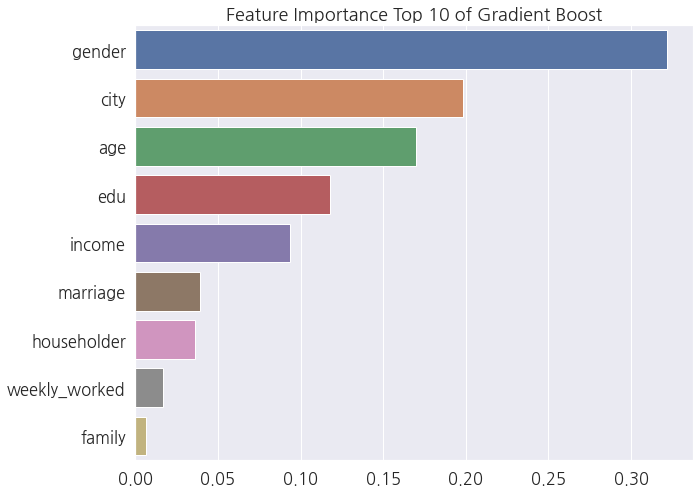

In [29]:
# GradientBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 35, learning_rate = 0.3, max_depth = 3, max_features = 3, random_state = 0)
model.fit(train_X, train_y)
prediction_gb = model.predict(test_X)
print('Accuracy for gradient boost is', metrics.accuracy_score(prediction_gb, test_y))

ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X.columns)
ft_top10 = ft_series.sort_values(ascending = False)[:10]
#ft_top10.index = ['여성', '70세 이상', '대졸 이상', '제주', '사별/이혼', '강원', '경기', '대전', '주간 근무 O', '고졸']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 10 of Gradient Boost')
sns.barplot(x = ft_top10, y = ft_top10.index)
plt.show()

### 더미변수화 후 그래디언트부스팅

In [30]:
from sklearn.model_selection import train_test_split

df_gb = df[['gender', 'city', 'age', 'edu', 'target']]
train_gb, test_gb = train_test_split(df_gb, test_size = 0.3, random_state = 0, stratify = df['target'])
train_X_gb = train_gb[train_gb.columns[:-1]]
train_y_gb = train_gb[train_gb.columns[-1:]]
test_X_gb = test_gb[test_gb.columns[:-1]]
test_y_gb = test_gb[test_gb.columns[-1:]]

train_X_dummy_gb = pd.get_dummies(train_X_gb, columns = ['gender', 'city', 'age', 'edu'], drop_first = True)
test_X_dummy_gb = pd.get_dummies(test_X_gb, columns = ['gender', 'city', 'age', 'edu'], drop_first = True)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

params = { 'n_estimators' : range(5, 50, 10),
           'max_depth' : range(3, 5),
           'learning_rate' : np.linspace(0.1, 1, 10),
           'max_features' : range(1, 4)
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
gb_clf = GradientBoostingClassifier(random_state = 0)
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(train_X_dummy_gb, train_y_gb)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.30000000000000004, 'max_depth': 3, 'max_features': 3, 'n_estimators': 45}
최고 예측 정확도: 0.7287


c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train accuracy score is 0.7325845891384702
Test Accuracy for gradient boost is 0.7127694859038143


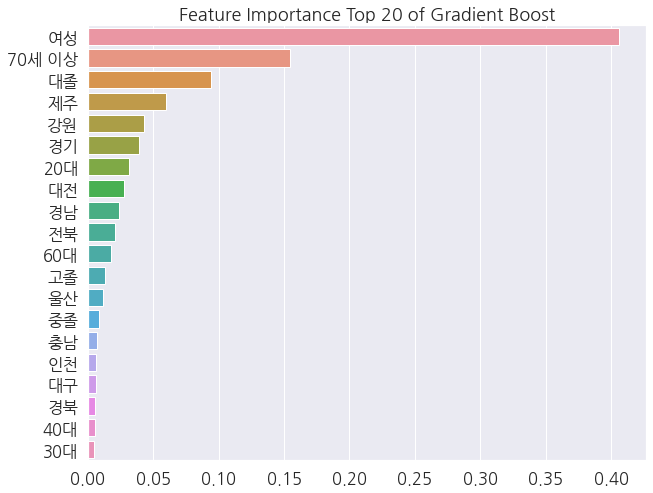

In [45]:
# GradientBoost Classifier
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 45, learning_rate = 0.30000000000000004, max_depth = 3, max_features = 3, random_state = 0)
model.fit(train_X_dummy_gb, train_y_gb)
pred_y = model.predict(train_X_dummy_gb)
train_acc = accuracy_score(y_true = train_y_gb, y_pred = pred_y)
print('Train accuracy score is', train_acc)
prediction_gb = model.predict(test_X_dummy_gb)
print('Test Accuracy for gradient boost is', metrics.accuracy_score(prediction_gb, test_y_gb))

ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy_gb.columns)
ft_top20 = ft_series.sort_values(ascending = False)[:20]
ft_top20.index = ['여성', '70세 이상', '대졸', '제주', '강원', '경기', '20대', '대전', '경남', '전북', '60대', '고졸', '울산', '중졸', '충남', '인천', '대구', '경북', '40대', '30대']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 20 of Gradient Boost')
sns.barplot(x = ft_top20, y = ft_top20.index)
plt.show()